# Model Selection

In [1]:
import sys
from pathlib import Path

project_root = Path().resolve().parent
sys.path.append(str(project_root))

In [2]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from config.features import CAT_FEATURES
from src.preprocess import preprocess_data

# sklearn utilities
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OrdinalEncoder

from imblearn.pipeline import Pipeline as ImbalancePipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.ensemble import RUSBoostClassifier

from lightgbm import LGBMClassifier

# sklearn models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
train = pd.read_parquet('../data/train.parquet')
sample_train = train.groupby('isFraud', group_keys=False)[train.columns].apply(lambda x: x.sample(frac=0.3, random_state=42))

print(train.shape)
print(sample_train.shape)

(590540, 450)
(177162, 450)


In [4]:
X = sample_train.drop(columns=['isFraud'])
y = sample_train['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print(X_train.shape)
print(y_train.shape)

(124013, 449)
(124013,)


In [5]:
del train, sample_train

gc.collect()

0

### Pre-processing

In [6]:
pca_features = X_train.columns[X_train.columns.str.startswith('V')]
cat_features = np.unique(CAT_FEATURES + X_train.select_dtypes(include=['object']).columns.tolist())
num_features = [col for col in X_train.columns if col not in cat_features and col not in pca_features]

In [7]:
X_train = X_train.replace([np.inf, -np.inf], -999)
X_test = X_test.replace([np.inf, -np.inf], -999)

In [8]:
categorical_transformer = Pipeline(steps=[
    ('to_string', FunctionTransformer(lambda X: X.astype(str))),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

pca_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=90))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_features),
        ('num', numeric_transformer, num_features),
        ('pca', pca_transformer, pca_features)
    ],
    remainder='passthrough'
)

In [9]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [10]:
del X_train, X_test

#### Model Selection

In [11]:
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train_transformed, y_train)

y_pred = decision_tree.predict(X_test_transformed)

In [12]:
train_score = decision_tree.score(X_train_transformed, y_train)
test_score = decision_tree.score(X_test_transformed, y_test)

print("Train score: {}".format(train_score))
print("Test score: {}".format(test_score))

Train score: 1.0
Test score: 0.9298199401682063


In [13]:
confusion_matrix(y_test, y_pred)

array([[48552,  2737],
       [  993,   867]])

In [14]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

Accuracy: 0.9298199401682063
Precision: 0.24056603773584906
Recall: 0.4661290322580645
F1 Score: 0.31734992679355783


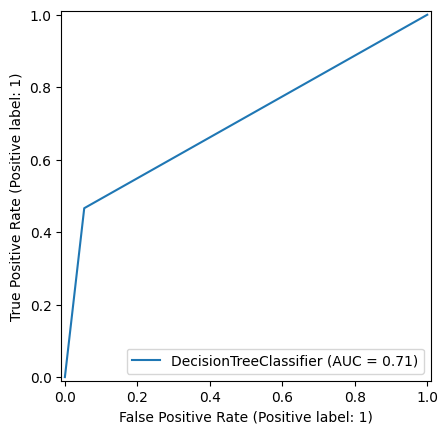

In [15]:
RocCurveDisplay.from_estimator(decision_tree, X_test_transformed, y_test)

#### Cross Validation

In [16]:
np.random.seed(42)

results = {}

k_folds = 5
cv = StratifiedKFold(n_splits=k_folds, shuffle=True)

models = {
    'LGBM': LGBMClassifier(verbose=-1),
    'RF': RandomForestClassifier(),
    'BC': BaggingClassifier(),
    'DT': DecisionTreeClassifier(),
}

for name, model in models.items():
    scores = cross_val_score(model, X_train_transformed, y_train, cv=cv, scoring='roc_auc')
    results[name] = scores

    print(f'{name}: {scores.mean()} ({scores.std()})')

LGBM: 0.9089896332103177 (0.006103523683363027)
RF: 0.8836014799467632 (0.004004628289545783)
BC: 0.8236333199098661 (0.004826254545044811)
DT: 0.6903031740290465 (0.0077462260537826)


In [17]:
results

{'LGBM': array([0.91982421, 0.90476203, 0.90185853, 0.90916715, 0.90933624]),
 'RF': array([0.88304536, 0.89043584, 0.88431055, 0.88213927, 0.87807638]),
 'BC': array([0.82802507, 0.81605936, 0.82113626, 0.82942668, 0.82351924]),
 'DT': array([0.67871655, 0.68736598, 0.70039392, 0.69728908, 0.68775033])}

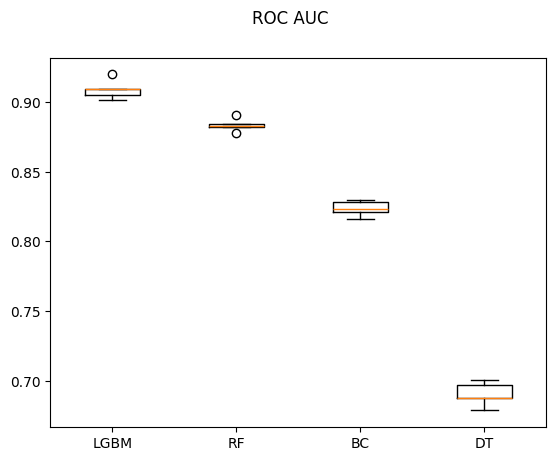

In [18]:
fig = plt.figure() 
fig.suptitle('ROC AUC') 
ax = fig.add_subplot(111) 
plt.boxplot(results.values()) 
ax.set_xticklabels(results.keys()) 
plt.show()

#### Resampling Methods

In [19]:
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)

X_train_res, y_train_res = undersampler.fit_resample(X_train_transformed, y_train)

scores = cross_val_score(RandomForestClassifier(random_state=42), X_train_res, y_train_res, cv=cv, scoring='roc_auc')
print(f'UNDER_RF: {scores.mean()} ({scores.std()})')

results['UNDER_RF'] = scores

UNDER_RF: 0.8827072415548823 (0.007736539395623477)


In [20]:
rus_boost = RUSBoostClassifier(random_state=42)

scores = cross_val_score(rus_boost, X_train_transformed, y_train, cv=cv, scoring='roc_auc')
print(f'RUSB: {scores.mean()} ({scores.std()})')

results['RUSB'] = scores

RUSB: 0.8471055236514479 (0.011228064911570117)


In [21]:
smote = SMOTE(random_state=42)

X_train_res, y_train_res = smote.fit_resample(X_train_transformed, y_train)

scores = cross_val_score(LGBMClassifier(random_state=42, verbose=-1), X_train_res, y_train_res, cv=cv, scoring='roc_auc')
print(f'SMOTE_LGBM: {scores.mean()} ({scores.std()})')

results['SMOTE_LGBM'] = scores

SMOTE_LGBM: 0.9964962199283487 (0.00032919720666282275)


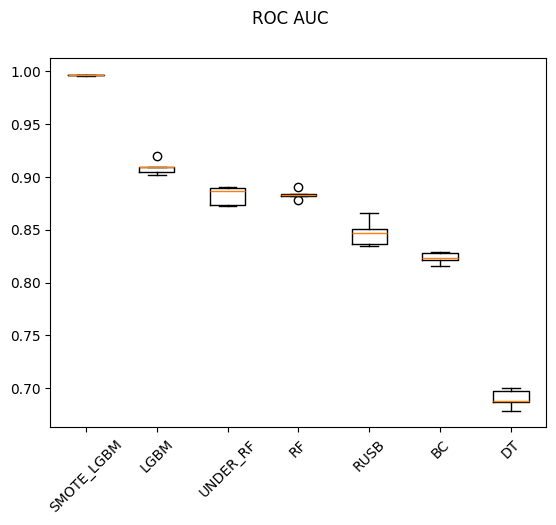

In [22]:
sorted_results = dict(sorted(results.items(), key=lambda x: np.median(x[1]), reverse=True))

fig = plt.figure() 
fig.suptitle('ROC AUC') 
ax = fig.add_subplot(111) 
plt.boxplot(sorted_results.values()) 
ax.set_xticklabels(sorted_results.keys(), rotation=45) 
plt.show()